# ISS2niche

In [1]:
import sys
import logging
import pandas as pd
import scanpy as sc

In [2]:
sys.path.append("..")
import iss2niche as i2n

In [3]:
logging.basicConfig(level=logging.INFO)

## load data

In [4]:
iss_ad = sc.read_h5ad("../data/C172ii_xenium_matrix.h5ad")

In [5]:
sc.pp.filter_cells(iss_ad, min_genes=1)

In [6]:
iss_ad

AnnData object with n_obs × n_vars = 152411 × 310
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [7]:
sc.pp.normalize_total(iss_ad)
sc.pp.log1p(iss_ad)

In [8]:
iss_ad.X.min(), iss_ad.X.max(), iss_ad.raw

(np.float32(0.0), np.float32(5.081404), None)

In [9]:
logging.basicConfig(level=logging.INFO)

In [10]:
sc.pp.neighbors(iss_ad, n_neighbors=5, use_rep='spatial')

/Users/jp30/miniforge3_use/envs/iss2niche/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
ad = sc.read_h5ad("../data/suspension_subsampled_20Sep24.h5ad")

In [12]:
sc.pp.filter_cells(iss_ad, min_genes=1)

In [13]:
ad

AnnData object with n_obs × n_vars = 10000 × 34170
    obs: 'run_batch', 'run_id', 'trisomy', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch', 'pcw', 'brc_code', 'anatomical_site', 'relative_position', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'QC', 'S_score', 'G2M_score', 'phase', 'batch_key', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'doublet_cls', 'annot_endo', 'annot_stroma', 'annot_schwann', 'annot_immune', 'annot_neuronal', 'annot', 'cell_type_coarse'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-10', 'gene_ids-11', 'gene_ids-12', 'gene_ids-13', 'gene_ids-14', 'gene_ids-15', 'gene_ids-16', 'gene_ids-17', 'gene_ids-18', 'gene_ids-19', 'gene_ids-2', 'gene_ids-20', 'gene_ids-21', 'gene_ids-22', 'gene_ids-23', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6

In [14]:
ad.X.min(), ad.X.max(), ad.raw

(np.float32(0.0), np.float32(8.310645), None)

## select genes

In [15]:
gene_sel = i2n.select_genes(
    suspension=ad,
    spatial=iss_ad,
    kind='hvg',
    min_disp=0.1,
)

INFO:iss2niche.gene_selection:select overlapping genes
INFO:iss2niche.gene_selection:select highly variable genes


In [16]:
len(gene_sel)

46

## transfer labels

In [17]:
res_ad = i2n.transfer_labels(
    suspension=ad,
    spatial=iss_ad,
    genes=gene_sel,
    labels='annot',
    train_kwargs=dict(use_rep='X'),
    predict_kwargs=dict(use_rep='X'),
)

INFO:iss2niche.label_transfer:subsetting to 46 genes
INFO:iss2niche.label_transfer:training logistic regression model for annot
INFO:iss2niche.label_transfer:predicting labels for annot
INFO:iss2niche.label_transfer:46 features used for prediction
INFO:iss2niche.label_transfer:compiling results
INFO:iss2niche.label_transfer:adding predicted labels for annot to spatial dataset


In [18]:
res_ad.obs = pd.merge(
    res_ad.obs,
    res_ad.uns['label_transfer']['annot']['prob'],
    left_index=True, right_index=True,
)

In [19]:
res_ad

AnnData object with n_obs × n_vars = 152411 × 310
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'cell_labels', 'n_genes', 'annot', 'ASTROCYTE', 'Arach_FIB', 'Art_EC1', 'Art_EC2', 'BBB_EC1', 'BBB_EC2', 'CYCLING_GLIOBLAST', 'CYCLING_PRE_ASTROCYTE', 'CYCLING_RG', 'Cycling_FIB', 'Cycling_SCP', 'DC', 'Dura_FIB1', 'Dura_FIB2', 'Early_ERY', 'Early_MK', 'Eo/Baso', 'GLIOBLAST', 'Immature_B', 'Late_ERY', 'Late_MK', 'MP_LYVE1+', 'MP_LYVE1+_FOLR2+', 'MP_LYVE1+_ICAM1', 'MP_LYVE1+_cycling', 'Mast', 'Mid_ERY', 'Mono', 'Myo_FIB', 'NEUROBLAST_1', 'NEUROBLAST_2', 'NEURON', 'OC', 'PERI1', 'PERI2', 'PRE_ASTROCYTE', 'Pia_FIB1', 'Pia_FIB2', 'Plasma_B', 'Pre_B', 'Pre_OB', 'Pre_Pro_B', 'Pro_B', 'RG', 'SCHWANN', 'SCP', 'Satellite_GLIA', 'T/NK', 'Ven_EC1', 'Ven_EC2', 'YS_ERY'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', '

In [20]:
res_ad.obs['annot'].value_counts()

annot
NEURON                   73588
Dura_FIB1                18553
RG                       18228
NEUROBLAST_1             11984
ASTROCYTE                 7124
GLIOBLAST                 5083
Myo_FIB                   4669
Pia_FIB1                  2714
Dura_FIB2                 2425
Pia_FIB2                  2264
Art_EC2                   1534
CYCLING_GLIOBLAST         1442
NEUROBLAST_2              1310
Cycling_FIB                585
PERI2                      387
MP_LYVE1+                   82
Late_ERY                    65
Early_MK                    57
BBB_EC2                     53
PERI1                       50
Mono                        38
Ven_EC1                     36
Late_MK                     26
YS_ERY                      23
BBB_EC1                     19
T/NK                        19
CYCLING_RG                  12
Early_ERY                   11
Arach_FIB                   11
Ven_EC2                      7
Cycling_SCP                  4
Satellite_GLIA               4
Mi

### plots

In [21]:
logging.basicConfig(level=logging.INFO)

... storing 'annot' as categorical


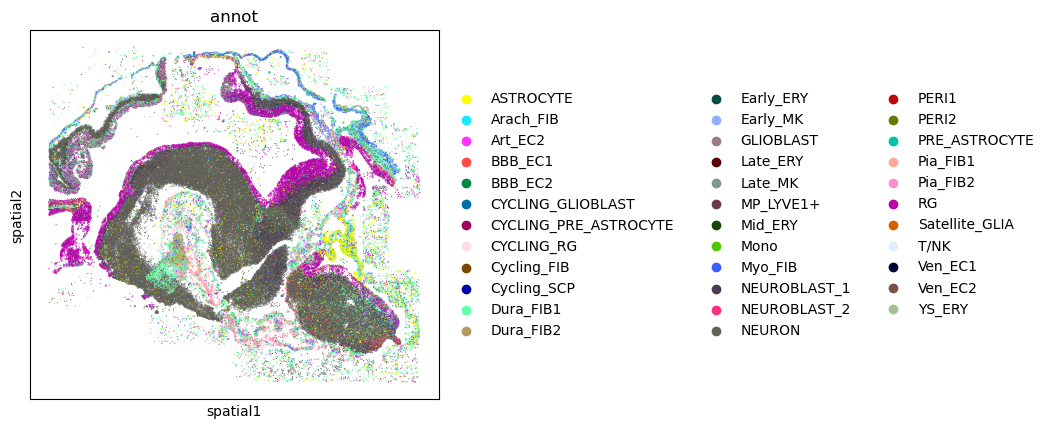

In [22]:
sc.pl.spatial(res_ad, color='annot', spot_size=20)

In [23]:
# res_ad.obs['Pia'] = res_ad.obs['annot'].isin(['Pia_FIB1', 'Pia_FIB2'])
# res_ad.obs['Dura'] = res_ad.obs['annot'].isin(['Dura_FIB1', 'Dura_FIB2'])
# res_ad.obs['Arachnoid'] = res_ad.obs['annot'].isin(['Arach_FIB'])

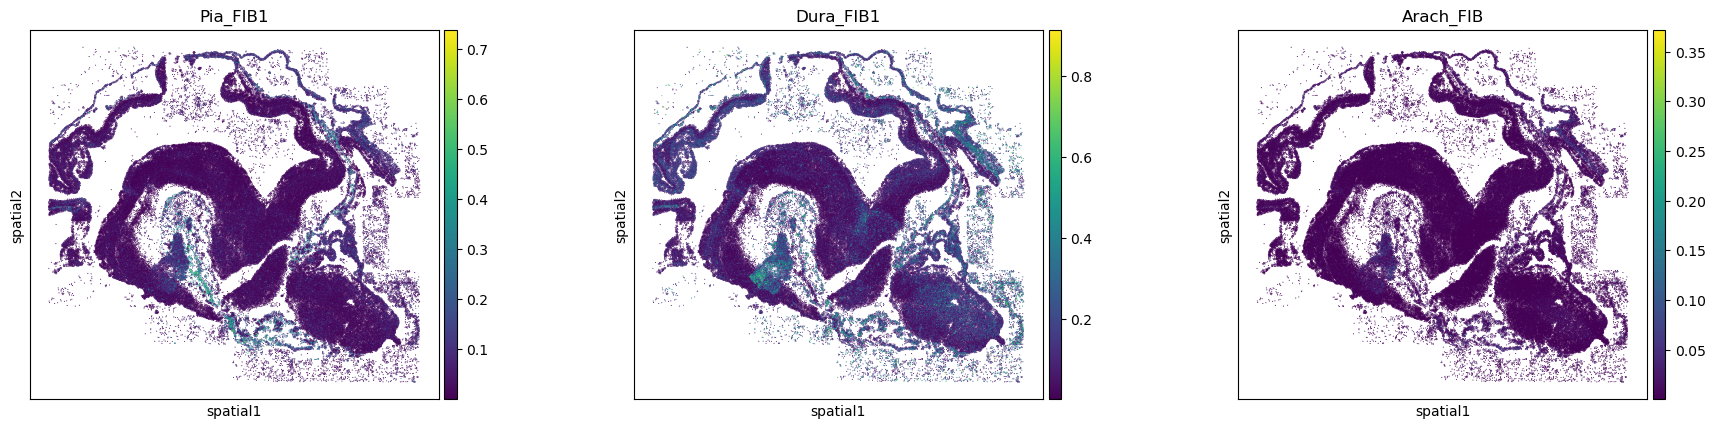

In [24]:
sc.pl.spatial(res_ad, color=['Pia_FIB1', 'Dura_FIB1', 'Arach_FIB'], spot_size=20)

## analyse niches

In [25]:
res_ad.obsm['annot_prob'] = res_ad.uns['label_transfer']['annot']['prob'].loc[res_ad.obs_names].to_numpy()

In [26]:
agg_prob = i2n.aggregate_neighbors(
    spatial=res_ad,
    labels='annot_prob',
)

In [27]:
res = i2n.find_niches(agg_prob)

/Users/jp30/miniforge3_use/envs/iss2niche/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/jp30/miniforge3_use/envs/iss2niche/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/jp30/miniforge3_use/envs/iss2niche/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/jp30/miniforge3_use/envs/iss2niche/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/jp30/miniforge3_use/envs/iss2niche/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: Conve

In [28]:
res['membership'].shape

(51, 9)

In [29]:
res['features'].shape

(9, 51)

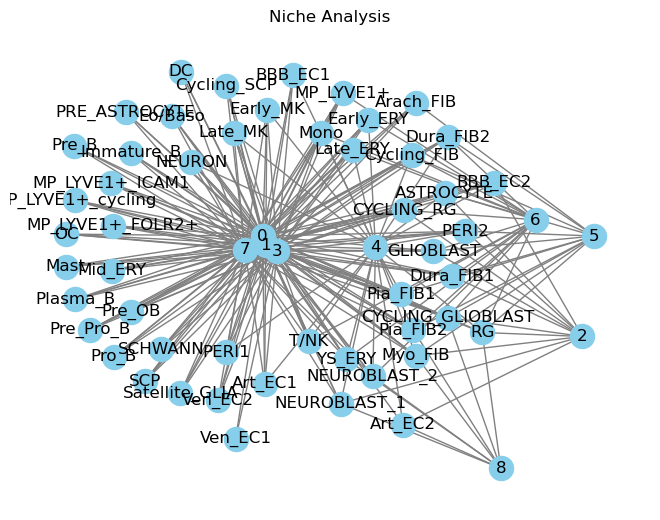

In [30]:
i2n.plot_niches(
    membership=res['membership'],
    features=res['features'],
    labels=res_ad.uns['label_transfer']['annot']['prob'].columns,
)

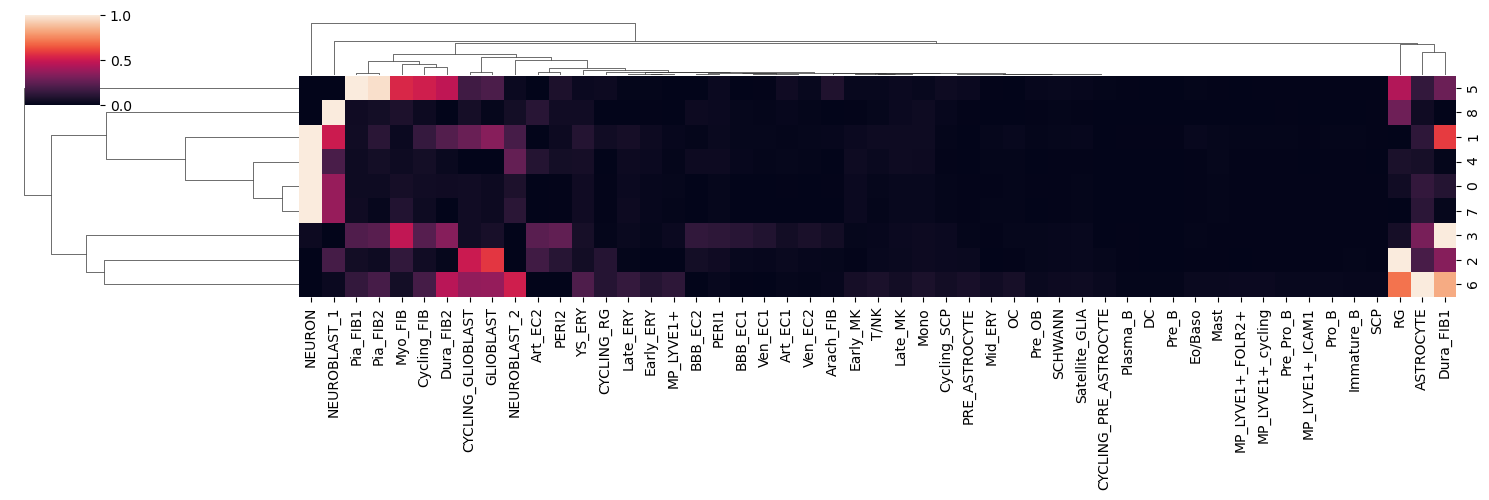

In [39]:
import seaborn as sns
sns.clustermap(pd.DataFrame(res['membership'], index=res_ad.uns['label_transfer']['annot']['prob'].columns).T, figsize=(15,5), standard_scale=0)